#### Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as pt
# from dash import Dash, dcc, html, Input, Output

import warnings
warnings.filterwarnings('ignore')

#### Reading the data

In [ ]:
df = pd.read_csv('multiTimeline.csv')
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
df.head()

,Month,Heater,Air conditioner
0,2005-01-01,6,10
1,2005-02-01,4,10
2,2005-03-01,3,12
3,2005-04-01,3,15
4,2005-05-01,3,24


#### Time series Plot

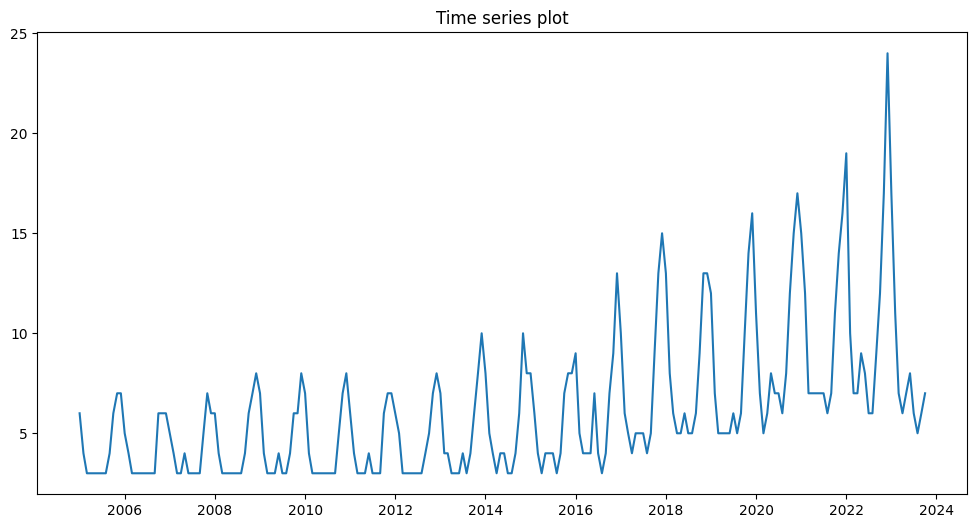

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(df['Month'],df['Heater'], label='Time Series Plot')
plt.title('Time series plot')
plt.show()

#### Multiple Linear Regression

$ m_{t} = a_{0} + a_{1}t $ \
$ s_{t} = b_{0}*\sin\left(\frac{2\pi}{d}t\right) + b_{1}*\cos\left(\frac{2\pi}{d}t\right)$  


Here, $d=12$   
$\therefore \ \ \ s_{t} = b_{0}*\sin\left(\frac{\pi}{6}t\right) + b_{1}*\cos\left(\frac{\pi}{6}t\right)$

We go forward with parameterized model.  
$y = X\beta$   
where, $X$ is a $(n\_obs \times 4)$ matrix and $\beta$ is $(4 \times 1)$   

$\therefore \ \ \beta = \left[ \begin{array}{c} a_0 \\ a_1 \\ b_0 \\ b_1 \end{array} \right] \ \ \ \ \ ; \ \ \ \ \ X_i = \left[ \begin{array}{cccc} 1 & i & \cos\left( \frac{\pi}{6}i \right) & \sin\left( \frac{\pi}{6}i \right) \end{array} \right]$

We estimate $\beta$ by:

$\hat{\beta} = \left(X^TX\right)^{-1}X^Ty$

In [ ]:
m = np.array([np.ones(len(df)), (df.index.values+1)]).T
s = np.array([np.sin(np.pi*(df.index.values+1)/6), np.cos(np.pi*(df.index.values+1)/6)]).T

In [ ]:
# m + s
m_s = np.hstack((m, s))
print(m_s)

[[ 1.00000000e+00  1.00000000e+00  5.00000000e-01  8.66025404e-01]
 [ 1.00000000e+00  2.00000000e+00  8.66025404e-01  5.00000000e-01]
 [ 1.00000000e+00  3.00000000e+00  1.00000000e+00  6.12323400e-17]
 [ 1.00000000e+00  4.00000000e+00  8.66025404e-01 -5.00000000e-01]
 [ 1.00000000e+00  5.00000000e+00  5.00000000e-01 -8.66025404e-01]
 [ 1.00000000e+00  6.00000000e+00  1.22464680e-16 -1.00000000e+00]
 [ 1.00000000e+00  7.00000000e+00 -5.00000000e-01 -8.66025404e-01]
 [ 1.00000000e+00  8.00000000e+00 -8.66025404e-01 -5.00000000e-01]
 [ 1.00000000e+00  9.00000000e+00 -1.00000000e+00 -1.83697020e-16]
 [ 1.00000000e+00  1.00000000e+01 -8.66025404e-01  5.00000000e-01]
 [ 1.00000000e+00  1.10000000e+01 -5.00000000e-01  8.66025404e-01]
 [ 1.00000000e+00  1.20000000e+01 -2.44929360e-16  1.00000000e+00]
 [ 1.00000000e+00  1.30000000e+01  5.00000000e-01  8.66025404e-01]
 [ 1.00000000e+00  1.40000000e+01  8.66025404e-01  5.00000000e-01]
 [ 1.00000000e+00  1.50000000e+01  1.00000000e+00  1.19434012e

$\hat{\beta}$

In [ ]:
# coefficients
print((np.linalg.inv(m_s.T @ m_s) @ m_s.T @ df['Heater'].values).round(2))

[ 2.68  0.03 -0.16  2.99]


Predicted Values

$\hat{y} = X\hat{\beta}$

In [ ]:
# predicted values X@beta
pred = m_s @ np.linalg.inv(m_s.T @ m_s) @ m_s.T @ df['Heater']

In [ ]:
pred_df = pd.DataFrame(pred, columns=['Heater'])
pred_df['Month'] = df['Month']

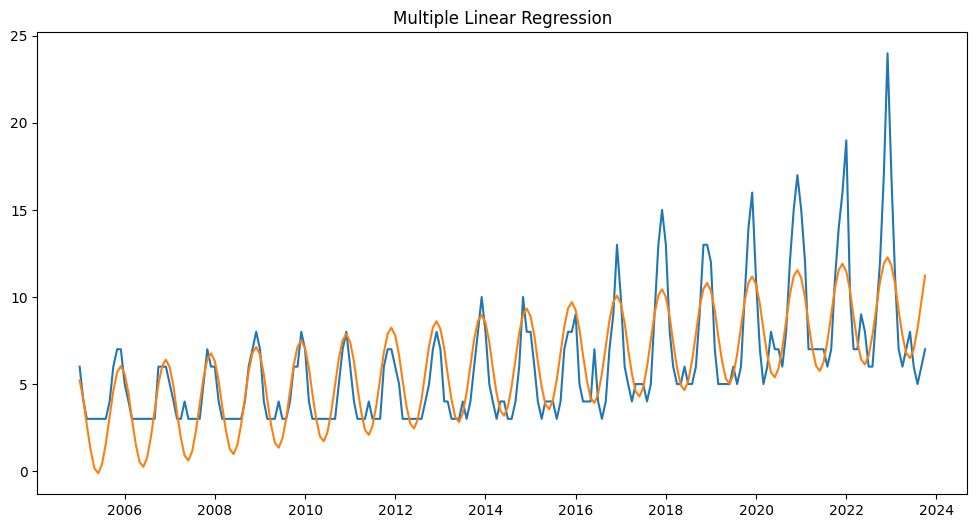

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(df['Month'],df['Heater'], label='actual')
plt.plot(pred_df['Month'], pred_df['Heater'], label='predicted')
plt.title('Multiple Linear Regression')
plt.show()

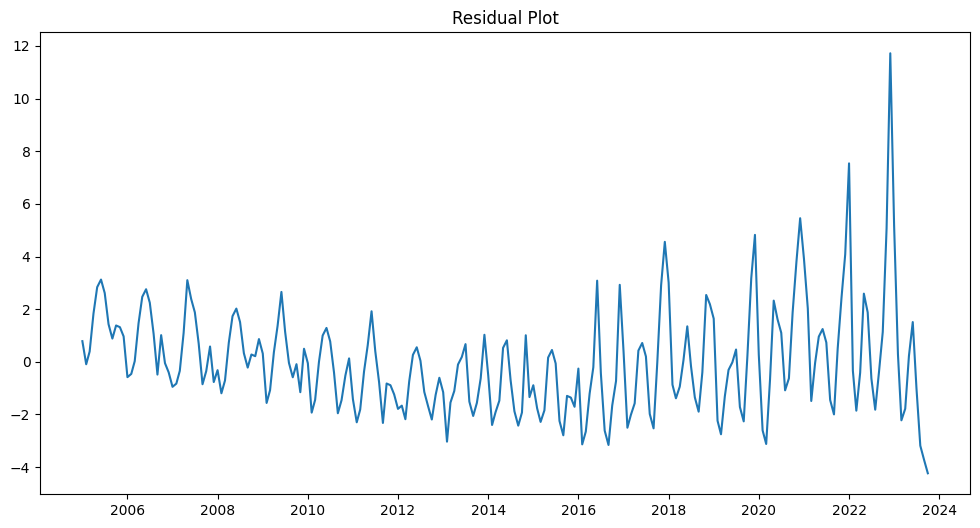

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(df['Month'], df['Heater']-pred_df['Heater'], label='residual')
plt.title('Residual Plot')
plt.show()

### Non parametrized Method

#### MA Filter method

In [ ]:
q = 6
d = 12
n = 226
n_train = 156
n_test = n - n_train

In [ ]:
def ma_filter(t, Y, d):
  q = int(d/2)
  n = len(Y)

  if t<q or t>n-1-q:
    return 0

  m = 0.5*Y[t-q] + 0.5*Y[t+q]

  for i in range(1, 2*q):
    m += Y[t - q + i]

  return m/d

$ \hat m_{t} = \frac{(0.5*x_{t-q} + x_{t-q+1} + ..... + x_{t+q-1} + 0.5*x_{t+q})}{d}$ where
$ d = 2q $ \
$ q < t \leq n-q $

In [ ]:
m_k = []
for k in range(0, n):
    m_k.append(ma_filter(k, df['Heater'], d))
m_k = np.array(m_k)

Computing the average $w_k$ of the deviations ${(x_{k+jd} − \hat m_{k+jd} ), q < k+j d ≤ n−q}$

In [ ]:
def wk(k, Y, d):
  k = k%d
  n = len(Y)
  q = d/2
  s = 0
  count = 0
  for j in range(0, n):
    if q <= k+j*d <= n-1-q:
      count += 1
      s += Y[k + j * d] - ma_filter(k + j * d, Y, d)
  if count == 0:
    return 0
  return float(s / count)

$ \hat s_{k} = w_{k} - \frac{1}{d} \sum_{i=1}^d w_{i}$ \
where $k = 1,......,d$

In [ ]:
a_wk = []
for k in range(0,12):
    a_wk.append(wk(k, df['Heater'], d))
mean_a_wk = np.mean(a_wk)

In [ ]:
s_k = []
for k in range(0,n):
    s_k.append(wk(k, df['Heater'], d) - mean_a_wk)
s_k = np.array(s_k)

##### Deseasonalized data

In [ ]:
dk = pd.DataFrame()
dk = df.copy()
dk['Heater'] = df['Heater'] - s_k
dk

,Month,Heater,Air conditioner
0,2005-01-01,2.725036,10
1,2005-02-01,4.125499,10
2,2005-03-01,4.856981,12
3,2005-04-01,5.141703,15
4,2005-05-01,4.582743,24
...,...,...,...
221,2023-06-01,9.472449,78
222,2023-07-01,7.919481,100
223,2023-08-01,7.350036,71
224,2023-09-01,7.431055,49


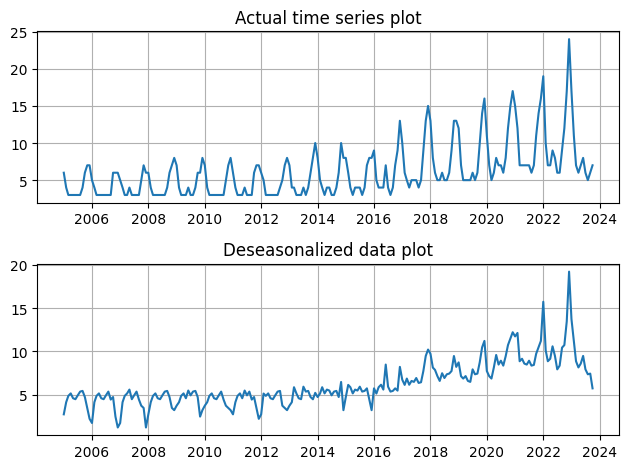

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(df['Month'],df['Heater'])
ax[1].plot(dk['Month'], dk['Heater'])
ax[0].set_title("Actual time series plot")
ax[1].set_title("Deseasonalized data plot")
fig.tight_layout()
ax[0].grid()
ax[1].grid()
plt.show()

##### Stationary data (data with no trend and seasonality)

In [ ]:
s_df = pd.DataFrame()
s_df['Month'] = df['Month']
s_df['Heater_res'] = df['Heater'] - s_k - m_k

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(s_df['Heater_res'])
print("ADF test statistic: ", adf_test[0])
print("p-value: ", adf_test[1])
print("Critical values: ", adf_test[4])

ADF test statistic:  1.1659154138107737
p-value:  0.9957417197181866
Critical values:  {'1%': -3.461136478222043, '5%': -2.875078880098608, '10%': -2.5739861168199027}


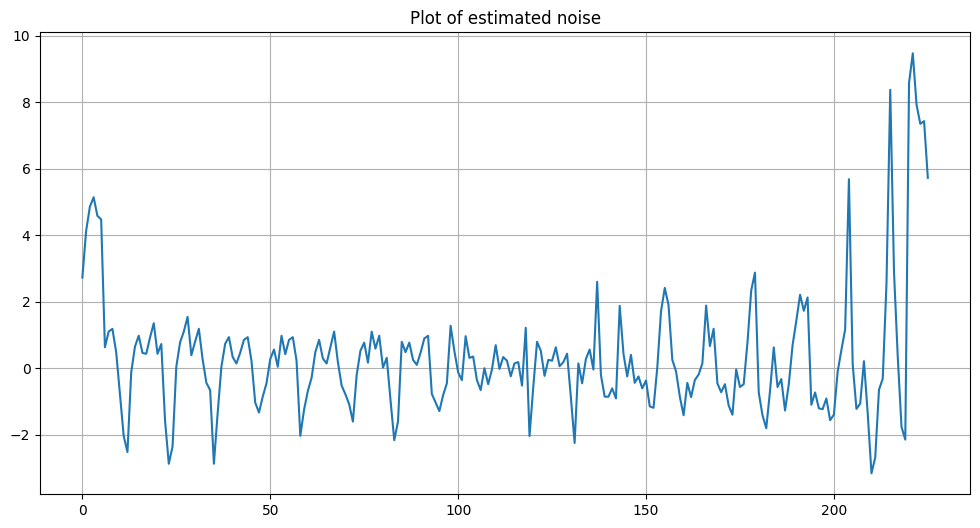



 Estimated Noise obtained by subtracting the estimated seasonal and trend components from the original data.


In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(s_df['Heater_res'])
plt.title('Plot of estimated noise')
plt.grid()
plt.show()
print("\n")
print(" Estimated Noise obtained by subtracting the estimated seasonal and trend components from the original data.")

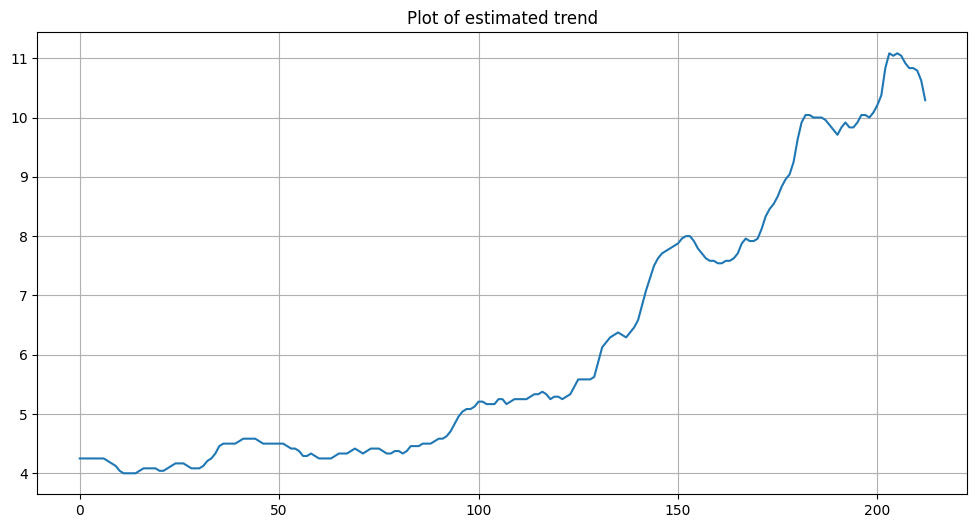



 Estimated Trend 


In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(m_k[q+1:n-q])
plt.title('Plot of estimated trend')
plt.grid()
plt.show()
print("\n")
print(" Estimated Trend ")

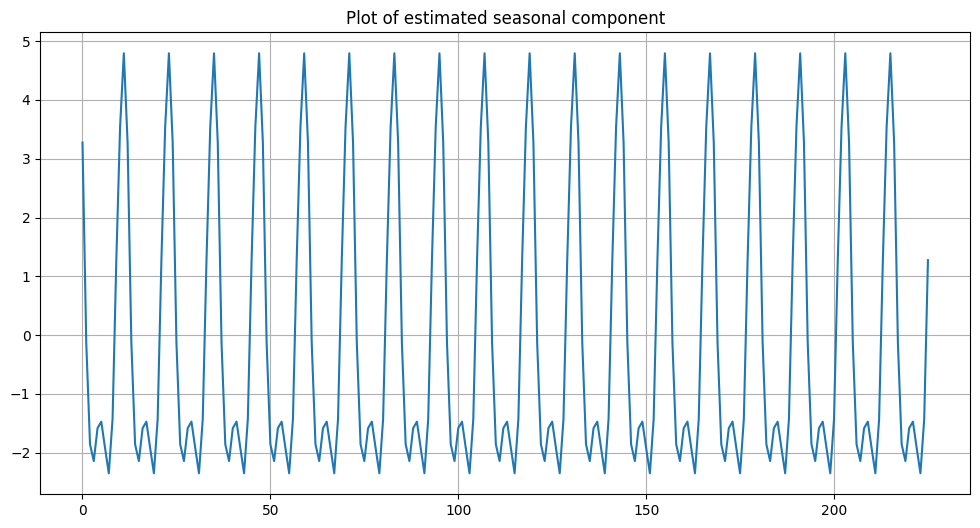



 The estimated seasonal component.


In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(s_k)
plt.title('Plot of estimated seasonal component')
plt.grid()
plt.show()
print("\n")
print(" The estimated seasonal component.")

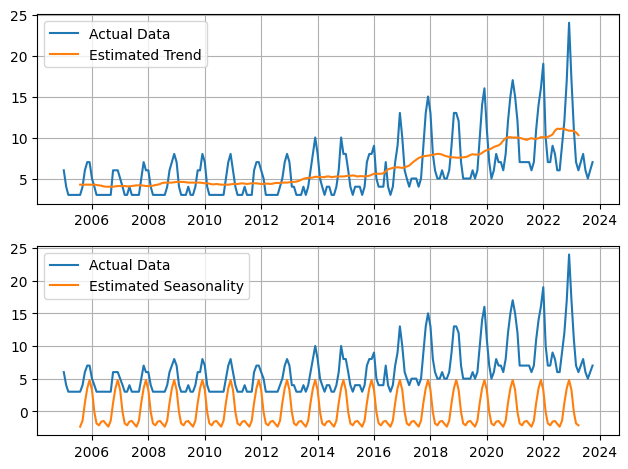

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(df['Month'],df['Heater'], label="Actual Data")
ax[0].plot(df['Month'][q+1:n-q], m_k[q+1:n-q], label="Estimated Trend" )
ax[1].plot(df['Month'],df['Heater'], label="Actual Data")
ax[1].plot(df['Month'][q+1:n-q], s_k[q+1:n-q], label="Estimated Seasonality" )
fig.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
def acf(dt, tc, lag):
    """
    Function to calculate auto-correlation coefficient of given lag

    Parameters
    ----------
    - dt (pd.DataFrame): The dataset used for processing
    - tc (string): Name of the Target Column
    - lag (int): Given lag

    Returns
    -------
    - (int): Computed Auto-correlation coefficient

    """
    n = len(dt)
    d1 = dt[tc]
    mean_data = np.mean(dt[tc])
    acf_value = sum(
        (d1[:n - lag] - mean_data).reset_index(drop=True) * (d1[lag:] - mean_data).reset_index(drop=True)) / sum(
        (d1 - mean_data).reset_index(drop=True) ** 2)
    return acf_value

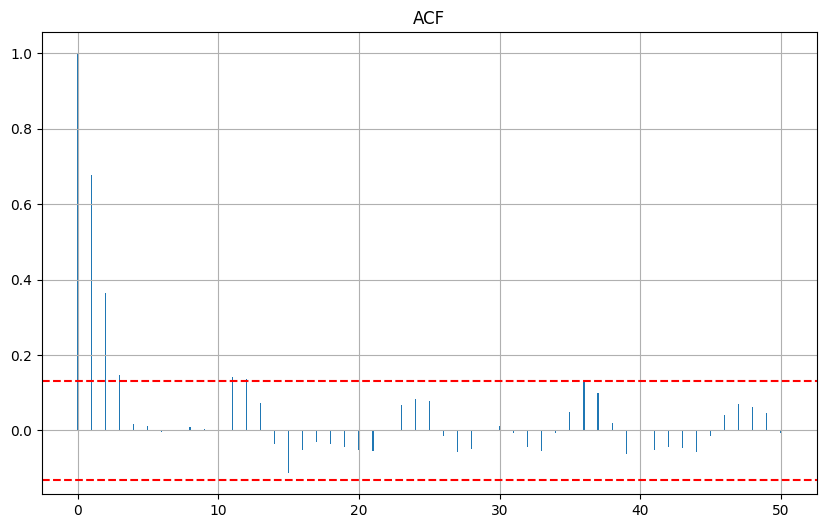

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.title('ACF')
plt.bar([i for i in range(0,51)],[acf(s_df, 'Heater_res', i) for i in range(0,51)], width = 0.08)
plt.axhline(y = 1.96/(len(s_df)**0.5), color = 'r', linestyle = '--')
plt.axhline(y = -1.96/(len(s_df)**0.5), color = 'r', linestyle = '--')
plt.grid()
plt.show()

#### Difference method

In [ ]:
df1 = df.copy()
te = df.copy()
te = te[12:]
te.drop(['Air conditioner'],axis=1,inplace=True)
df1['Heater'] = df1['Heater'].shift(d)
te['Heater'] = df['Heater'][d:] - df1['Heater'][d:]

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(te['Heater'])
print("ADF test statistic: ", adf_test[0])
print("p-value: ", adf_test[1])
print("Critical values: ", adf_test[4])

ADF test statistic:  -4.682798819557395
p-value:  9.064201076692845e-05
Critical values:  {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}


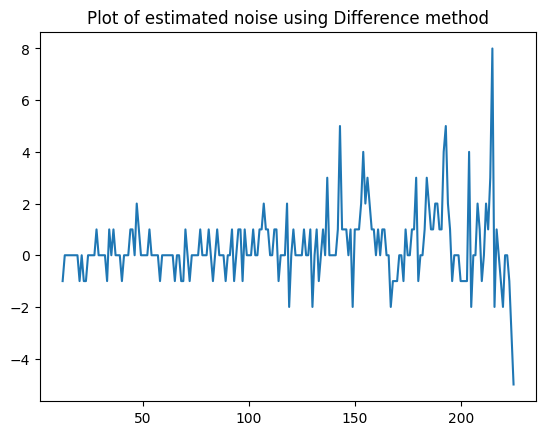

In [ ]:
plt.plot(te['Heater'])
plt.title("Plot of estimated noise using Difference method")
plt.show()

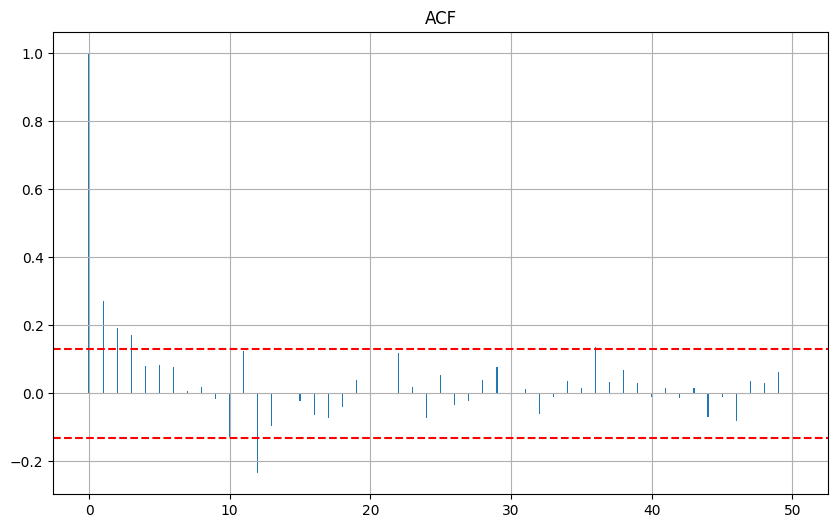

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.title('ACF')
plt.bar([i for i in range(0,51)],[acf(te, 'Heater', i) for i in range(0,51)], width = 0.08)
plt.axhline(y = 1.96/(len(s_df)**0.5), color = 'r', linestyle = '--')
plt.axhline(y = -1.96/(len(s_df)**0.5), color = 'r', linestyle = '--')
plt.grid()
plt.show()

### Forecasting

In [ ]:
# te1 = te.reset_index(drop=True)
te1 = te.copy()
te1

,Month,Heater
12,2006-01-01,-1.0
13,2006-02-01,0.0
14,2006-03-01,0.0
15,2006-04-01,0.0
16,2006-05-01,0.0
...,...,...
221,2023-06-01,0.0
222,2023-07-01,0.0
223,2023-08-01,-1.0
224,2023-09-01,-3.0


In [ ]:
# train_df = s_df[:n_train]
# test_df = s_df[n_train:]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(te1['Heater'],order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Heater   No. Observations:                  214
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -372.888
Date:                Fri, 13 Oct 2023   AIC                            749.776
Time:                        13:09:21   BIC                            756.498
Sample:                             0   HQIC                           752.493
                                - 214                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4501      0.041    -10.899      0.000      -0.531      -0.369
sigma2         1.9393      0.107     18.052      0.000       1.729       2.150
Ljung-Box (L1) (Q):                   3.69   Jarque-

In [ ]:
pred = model_fit.predict(start=0, end=213)

In [ ]:
pred

12     0.000000e+00
13    -9.999989e-01
14    -4.501040e-01
15    -9.994304e-17
16     5.696023e-23
           ...     
221   -1.549896e+00
222   -9.002080e-01
223   -1.609936e-16
224   -5.498960e-01
225   -2.099792e+00
Name: predicted_mean, Length: 214, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
rmse = sqrt(mean_squared_error(te1['Heater'], model_fit.predict(start=0, end=213)))
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)
print("RMSE: ", rmse)
print("Adjusted R2: ", adjusted_r2(r2_score(te1['Heater'], model_fit.predict(start=0, end=213)), n, 1))

RMSE:  1.3913700263369018
Adjusted R2:  -0.10453022703210979


In [ ]:
# test_1 = test_df.copy()
# train_1 = train_df.copy()
# test_1.rename(columns={'Heater_res':'Heater'},inplace=True)
# train_1.rename(columns={'Heater_res':'Heater'},inplace=True)
# test_1['Heater'] = pred

In [ ]:
# f_t = pd.concat([train_1, test_1])

In [ ]:
te1

,Month,Heater
12,2006-01-01,-1.0
13,2006-02-01,0.0
14,2006-03-01,0.0
15,2006-04-01,0.0
16,2006-05-01,0.0
...,...,...
221,2023-06-01,0.0
222,2023-07-01,0.0
223,2023-08-01,-1.0
224,2023-09-01,-3.0


In [ ]:
len(m_k)

226

In [ ]:
f_t = pd.DataFrame()
f_t['Month'] = df['Month'][12:]
f_t['Heater'] = te1['Heater'] + s_k[12:] + m_k[12:]

In [ ]:
f_t

,Month,Heater
12,2006-01-01,6.524964
13,2006-02-01,4.124501
14,2006-03-01,2.351353
15,2006-04-01,2.024964
16,2006-05-01,2.542257
...,...,...
221,2023-06-01,-1.472449
222,2023-07-01,-1.919481
223,2023-08-01,-3.350036
224,2023-09-01,-4.431055


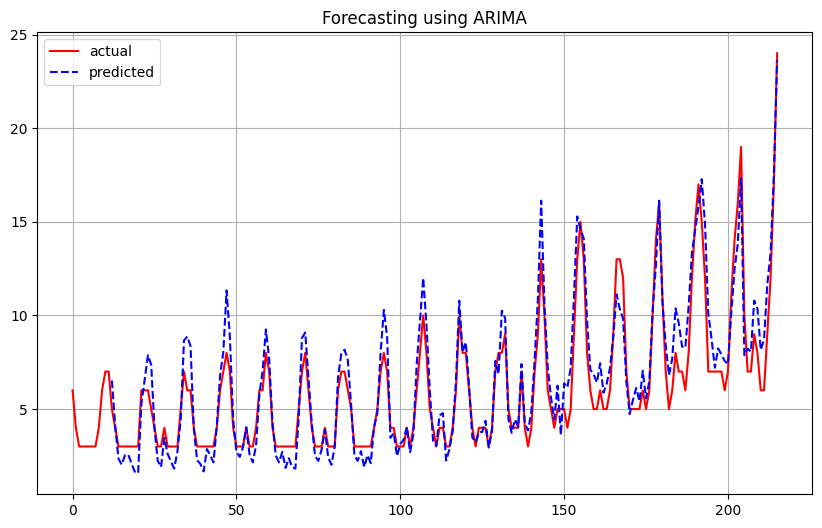

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(df['Heater'][:216], 'r', label='actual')
plt.plot(f_t['Heater'][:204], 'b--', label='predicted')
plt.title('Forecasting using ARIMA')
plt.grid()
plt.legend()
plt.show()